In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-03 12:14:40,975: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
import sys
!{sys.executable} -m pip install mitiq

In [17]:
# Importing mitiq and curve fitting
import mitiq
from mitiq import zne

from scipy.optimize import curve_fit

In [18]:
# Loading our image in the Quantum State
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)
np_test_image = np_test_image.reshape((4,4))
print("Original Image Pixel values: ")
print(np_test_image)


Original Image Pixel values: 
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


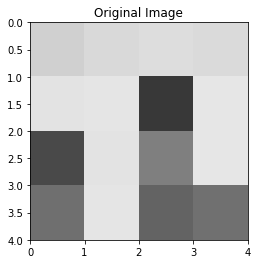

Normalized Image Pixel values: 
[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


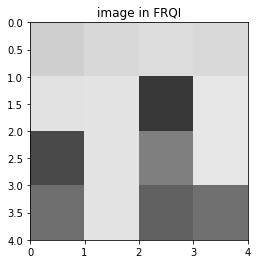

In [19]:
# Function to plot our image
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# The normalized image is too dark, so we brighten it with this method
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    
def plot_image4x4_denormalized(image, true_image, true_image_normalized, title: str):
    normalization_factor = 0.0
    for x in range(4):
        for y in range(4):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (4**2)
    
    image_plot = image / normalization_factor
    
    plt.title(title)
    plt.imshow(image_plot, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print("Normalized Image Pixel values: ")
print(np_test_image_normalized)

plot_image4x4_denormalized(np_test_image_normalized, np_test_image, np_test_image_normalized, 'image in FRQI')

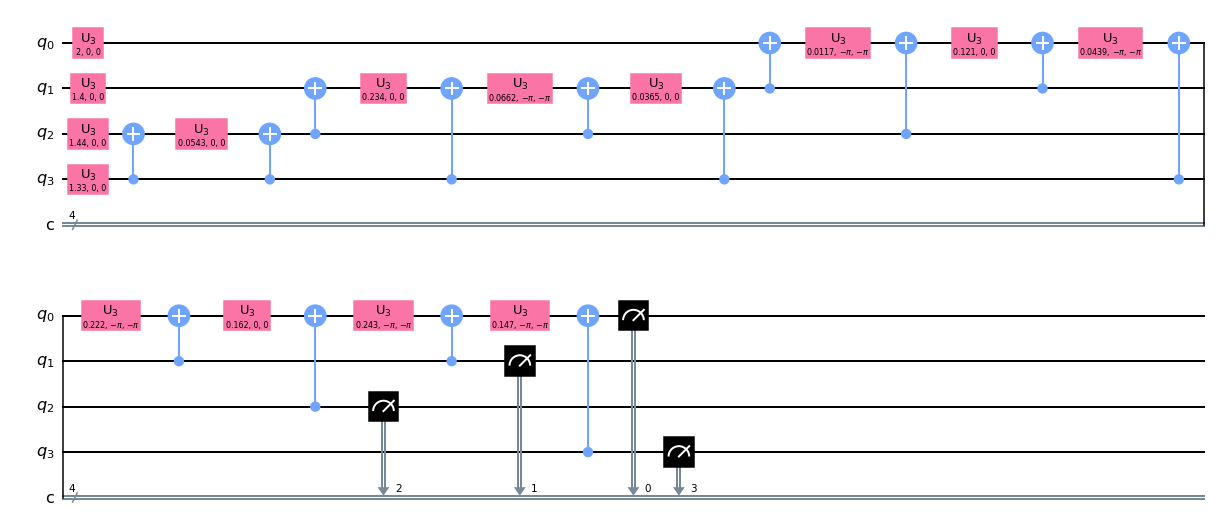

In [20]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(4,4)

qc_image.initialize(np_test_image_normalized.reshape(16))

qc_image.measure(range(4), range(4))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])

qc_image.draw()

Aer Simulator Output Image Pixel Values: 
[[0.2770379  0.29197603 0.29874738 0.28504386]
 [0.29453353 0.30248967 0.06123724 0.31104662]
 [0.09082951 0.31424513 0.16881943 0.31064449]
 [0.14491377 0.30618622 0.14230249 0.14747881]]


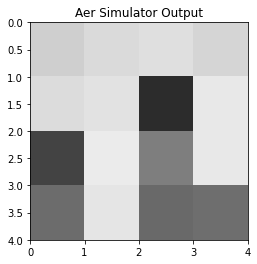

In [21]:
simulator_output = [0.2770379, 0.29197603, 0.29874738, 0.28504386,
 0.29453353, 0.30248967, 0.06123724, 0.31104662,
 0.09082951, 0.31424513, 0.16881943, 0.31064449,
 0.14491377, 0.30618622, 0.14230249, 0.14747881]
np_simulator_output = np.array(simulator_output).reshape((4,4))
print("Aer Simulator Output Image Pixel Values: ")
print(np_simulator_output)

plot_image4x4_denormalized(np_simulator_output, np_test_image, np_test_image_normalized, 'Aer Simulator Output')

In [22]:
# Calculating Error:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [23]:
# Routines to plot errors and extrapolations associated with each pixel
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, (int(scale_factors[-1]) + 1)])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, 5, 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()

In [24]:
# EDIT THIS CELL TO RUN AN EXPERIMENT!

# scale_factors is an array of noise multipliers
scale_factors = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

# Number of shots to run
shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

# Note the backend and Job_ID used!

ibmqfactory.load_account:WARNING:2022-10-03 12:45:38,059: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [ ]:
# Copy the backend and Job_ID in this cell:
# Backend: ibmq_kolkata Job_ID: 633ad987e50d9f0428104649
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('633ad987e50d9f0428104649')

print(kolkata_job)

In [14]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 4X4 IMAGE. I HAVE HARD CODED 16 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((4,4))

kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((4,4))

Traceback (most recent call last):
  Input In [14] in <cell line: 11>
    all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
NameError: name 'folded_circuits' is not defined

Use %tb to get the full traceback.


In [ ]:
# Plotting the outputs:
print("IBMQ_Kolkata Output Image Pixels:")
print(np_kolkata_output)
plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata - 100000 shots')

print("IBMQ_Kolkata (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata (w/ ZNE) - 100000 shots')

In [ ]:
# Calculating and Displaying the RMSE errors:
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 
print("IBMQ Kolkata error (100000 shots): ", (rmse_kolkata * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error (100000 shots): ", (rmse_zne * 100), "% per pixel")

In [ ]:
# Plotting all of the errors and extrapolations for each pixel
for y in range(4):
    for x in range(4):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)